<div style='background-color: rgba(220,220,220,0.1) ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: left ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 75% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Hamiltonian Monte Carlo - Notebook 2</div>
            <div style="font-size: x-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Munich Earth Skience School 2020</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Bayesian inference on Earthquake hypocenters accelerated with Hamiltonian Monte Carlo</div>
        </div>
    </div>
</div>

In this notebook, we'll look at cases where HMC is a particular good choice of algorithm for performing Bayesian inference. We will focus on larger datasets; **We'll try to locate multiple Earthquakes at once**, and investigate the benefits and drawbacks of doing this w.r.t. inferring parameters one Eartquake at a time.

To do this inference efficiently, I rewrote the forward, misfit and gradient functions to run for multiple Earthquakes at once by **using vectorized expressions**. This results in a significant performance gain, beneficial to both Metropolis-Hastings and Hamiltonian Monte Carlo sampling. These function are given below, but we won't get into the details.

Specifically, we do:
1. Inverse problem set up, accelerated;
2. Battle of the samplers: which sampler does best in limited time?
3. Comparison of single event and many event inference.

# Section 1: Definition of the inverse problem for many Earthquakes

This is a quick re-implementation of the functions of notebook 1, optimized for speed.

In [1]:
# This is a configuration step for the exercise
# ---------------------------------------------

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter
import tqdm.notebook as tqdm
import matplotlib.gridspec as _gridspec
from typing import List as _List
import time

# Custom imports from this project
from misc import marginal_grid
import samplers

plt.style.use('ggplot')

In [2]:
# Forward, misfit and gradients
def forward(
    m, station_x, station_z,
):

    assert m.shape == (m.size, 1)

    x = m[0:-1:3]
    z = m[1:-1:3]
    T = m[2:-1:3]
    v = m[-1]

    t_calc = T + ((x - station_x) ** 2.0 + (z - station_z) ** 2.0) ** 0.5 / v
    
    t_calc = T + (1.0 / v) * ((x - station_x) ** 2.0 + (z - station_z) ** 2.0) ** 0.5
    return t_calc


def misfit_opt(
    m,
    t_obs,  # Observations
    sigma_mat,
    station_x,
    station_z,
    depth_limit,  # Prior
    v_mean,  # Prior
    v_variance,  # Prior
):

    assert m.shape == (m.size, 1)

    x = m[0:-1:3]
    z = m[1:-1:3]
    T = m[2:-1:3]
    v = m[-1]

    t_calc = T + ((x - station_x) ** 2.0 + (z - station_z) ** 2.0) ** 0.5 / v

    misfit = (t_calc - t_obs) ** 2 / (2 * sigma_mat ** 2)
    misfit = np.sum(misfit)
    misfit += ((v - v_mean) ** 2) / (2.0 * v_variance)

    if np.any(z < 0.0) or np.any(z > depth_limit):
        misfit += np.inf

    if np.any(x < 0.0) or np.any(x > 30):
        misfit += np.inf

    return misfit.item()


def grad_opt(
    m,
    t_obs,  # Observations
    sigma_mat,
    station_x,
    station_z,
    depth_limit,  # Prior
    v_mean,  # Prior
    v_variance,  # Prior
):

    assert m.shape == (m.size, 1)

    x = m[0:-1:3]
    z = m[1:-1:3]
    T = m[2:-1:3]
    v = m[-1]

    d = ((x - station_x) ** 2.0 + (z - station_z) ** 2.0) ** 0.5

    # Data
    t_calc = T + d / v

    # Data gradients
    data_grad_x = (x - station_x) / (v * d)
    data_grad_z = (z - station_z) / (v * d)
    data_grad_v = -d / (v * v)
    data_grad_T = np.ones_like(data_grad_x)

    # Misfit gradient
    misfit_grad = 2 * (t_calc - t_obs) / (2 * sigma_mat ** 2)

    # Applying chain rule
    gx = np.sum(misfit_grad * data_grad_x, axis=1)
    gz = np.sum(misfit_grad * data_grad_z, axis=1)
    gT = np.sum(misfit_grad * data_grad_T, axis=1)
    gv = np.sum(misfit_grad * data_grad_v)

    # Compiling into total gradient
    total_grad = np.zeros_like(m)
    total_grad[0:-1:3, 0] = gx
    total_grad[1:-1:3, 0] = gz
    total_grad[2:-1:3, 0] = gT
    total_grad[-1, 0] = gv
    total_grad[-1] += (2 * (v - v_mean)) / (2.0 * v_variance)

    return total_grad

In [3]:
# Compilation into a class
class target_multiple:
    def __init__(
        self,
        t_obs,
        uncertainties,
        station_x,
        station_z,
        v_mean,
        v_std,
        depth_limit,
    ):

        # Sanity check
        if np.array([station_x, station_z, uncertainties]).size != station_x.size * 3:
            print('ERROR: "station_x, station_z, uncertainties" must have same length')
            raise NotImplementedError

        # Assign defaults
        self.t_obs = t_obs
        self.uncertainties = uncertainties
        self.sigma_mat = np.tile(
            uncertainties, (int(t_obs.size / uncertainties.size), 1)
        )
        self.station_x = station_x
        self.station_z = station_z
        self.v_mean = v_mean
        self.v_variance = v_std * v_std
        self.depth_limit = depth_limit

        # Some householding
        self.nevents = int(t_obs.size / uncertainties.size)

        self.labels = []
        for il in range(self.nevents):
            self.labels += [f"Horizontal source location {il+1}"]
            self.labels += [f"Vertical source location {il+1}"]
            self.labels += [f"Origin time {il+1}"]

        self.labels += ["Medium velocity"]
        self.labels += ["Misfit"]
        

        self.primitive_units = ["km", "km", "s"]
        self.units = self.primitive_units * self.nevents + [
            "km/s",
        ] + ["-"]

    def misfit(self, m):
        return misfit_opt(
            m,
            t_obs=self.t_obs,
            sigma_mat=self.sigma_mat,
            station_x=self.station_x,
            station_z=self.station_z,
            v_mean=self.v_mean,
            v_variance=self.v_variance,
            depth_limit=self.depth_limit,
        )

    def grad(self, m):
        return grad_opt(
            m,
            t_obs=self.t_obs,
            sigma_mat=self.sigma_mat,
            station_x=self.station_x,
            station_z=self.station_z,
            v_mean=self.v_mean,
            v_variance=self.v_variance,
            depth_limit=self.depth_limit,
        )

What we'll do now is generate 11 random Eartquakes in addition to the Earthquake from Notebook 1, and assemble the inverse problem with the same prior information as Notebook 1.

In [4]:
# Creating multiple events including the event from Notebook 1

# Prior information
depth_limit = 25.0
v_mean = 4.5
v_std = 1.0

# We generate 12 random source locations.
# We want to recreate the 'random events' every time the same,
# so we have to 'seed' the RNG.
np.random.seed(42)
m_true = []
n_events = 12

m_true.append(16.0)
m_true.append(15.0)
m_true.append(17.0)

for i in range(n_events - 1):
    source_x = np.random.uniform(5, 25)
    source_z = np.random.uniform(1, depth_limit - 5)
    origin_T = np.random.uniform(4, 20)
    m_true.append(source_x)
    m_true.append(source_z)
    m_true.append(origin_T)
    
# The last entry of the model vector is the medium velocity
v_exact = 5
m_true.append(v_exact)

# Create true model vector from the list
m_true = np.array(m_true, dtype=np.float64)[:, np.newaxis]

# Define station coordinates of the array
station_x = np.array([0, 15.0, 30.0])
station_z = np.array([0.0, 0.0, 0.0])

# Define uncertainties for the observed arrival time at
# each station. These are repeated for all events.
uncertainties = np.array([0.5, 0.3, 0.2])

# Forward model the data
t_obs = forward(m_true, station_x, station_z)

# Roll everything into a nice tidy object
target = target_multiple(
    t_obs, uncertainties, station_x, station_z, v_mean, v_std, depth_limit
)

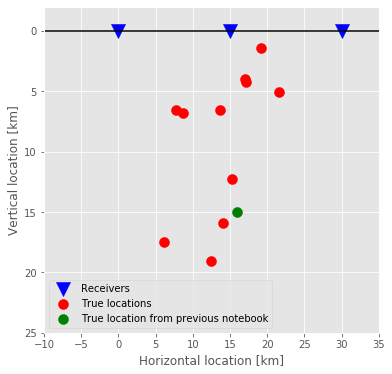

In [5]:
# Visualizing the receiver network and true locations
fig, axes = plt.subplots(figsize=(6,6))
axes.scatter(station_x, station_z, color='b', marker='v', s=200, label='Receivers')
axes.scatter(m_true[3:-1:3], m_true[4:-1:3], color='r', marker='.', s=400, label='True locations')
axes.scatter(m_true[0], m_true[1], color='g', marker='.', s=400, label='True location from previous notebook')
axes = plt.gca()
axes.set_xlabel("Horizontal location [km]")
axes.set_ylabel("Vertical location [km]")
axes.plot([-10, 35], [0, 0], "k")
axes.set_xlim([-10,35])
axes.set_ylim([25,-2])
axes.legend();

# Our inference is now 12 × 3 + 1 = 37 dimensional 

instead of 4 

# Section 2: Sampling with HMC and MH in limited time

This is the real test. We have **two major differences** from the sampling test in the previous notebook:

1. The sampling is time limited. We give both algorithms 10 seconds to run.
2. The HMC algorithm is optimized if the mass matrix is diagonal. This *greatly* speeds up momentum generation.

Point 2 might not seem like a fair choice, but actually is. The **MH algorithm allows for exactly the same information injection in the proposal step**, by supplying a covariance matrix to generate the perturbations. However, our implementation already assumed that this covariance matrix was a unit matrix, just like HMC now does.

In [6]:
# Perform HMC sampling
maxtime = 10.0 # seconds

# Starting model
m_start = 1.2 * m_true

# Tuning parameters
mass_matrix = np.eye(m_start.size)
epsilon = 0.02
nt = 50
number_of_samples = 500000

# Sampling
samples_HMC = samplers.sample_hmc_opt(target, m_start, nt, epsilon, number_of_samples, mass_matrix, maxtime=maxtime)

In [ ]:
# Perform MH sampling
maxtime = 10.0 # seconds

# Starting model
m_start = 1.2 * m_true

# Tuning
epsilon = 0.04
number_of_samples = 500000

# Sampling
samples_MH = samplers.sample_mh(target, m_start, epsilon, number_of_samples, maxtime=maxtime)

That's about what we expect, the MH algorithm generates about 100x more samples compared to HMC (on my system), but what about the quality?

I again precomputed a reference distribution, which is used as a benchmark.

In [ ]:
samples_HMC_REF = np.load("ref_solutions/twelve_events_reference_HMC_three_receivers.npy")

**The moment of truth** is here: which algorithm performs better with the same resources? 

We start again with the marginals for hypocenter location, and compare them to the reference solution.

In [ ]:
# Plotting Earthquake locations
figure, axess = plt.subplots(target.nevents, 3, figsize=(14, 4 * target.nevents))

# Select all samples where speed is fast
# selection = samples_HMC[:, samples_HMC[-2,:] < 4]

for i in range(target.nevents):
    axes = axess[i, 0]
    axes.hist2d(
        samples_HMC[i * 3, :],
        samples_HMC[i * 3 + 1, :],
        bins=25,
        range=[[0, 35], [-3, depth_limit]],
        cmap=plt.get_cmap("Greys"),
    )
    axes.invert_yaxis()
    axes.set_xlabel("Horizontal location [km]")
    axes.set_ylabel("Vertical location [km]")

    axes.scatter(m_true[i*3], m_true[i*3+1], 200, label="True location")
    axes.scatter(station_x, station_z, 200, label="Seismographs", marker='v')
    axes.plot([0, 35], [0, 0], "k")

    axes = axess[i, 1]
    axes.hist2d(
        samples_MH[i * 3, :],
        samples_MH[i * 3 + 1, :],
        bins=25,
        range=[[0, 35], [-3, depth_limit]],
        cmap=plt.get_cmap("Greys"),
    )
    axes.invert_yaxis()
    axes.set_xlabel("Horizontal location [km]")
    axes.set_ylabel("Vertical location [km]")

    axes.scatter(m_true[i*3], m_true[i*3+1], 200, label="True location")
    axes.scatter(station_x, station_z, 200, label="Seismographs", marker='v')
    axes.plot([0, 35], [0, 0], "k")
    
    axes = axess[i, 2]
    axes.hist2d(
        samples_HMC_REF[i * 3, :],
        samples_HMC_REF[i * 3 + 1, :],
        bins=25,
        range=[[0, 35], [-3, depth_limit]],
        cmap=plt.get_cmap("Greys"),
    )
    axes.invert_yaxis()
    axes.set_xlabel("Horizontal location [km]")
    axes.set_ylabel("Vertical location [km]")

    axes.scatter(m_true[i*3], m_true[i*3+1], 200, label="True location")
    axes.scatter(station_x, station_z, 200, label="Seismographs", marker='v')
    axes.plot([0, 35], [0, 0], "k")

    
axess[0, 0].set_title("HMC")
axess[0, 1].set_title("Metropolis-Hastings")
axess[0, 2].set_title("Reference solution");

The results should be staggering! At least to me they are. HMC, while not being great, is on average much closer to the reference distribution. In the same time, HMC was able to effectively generate more samples from the posterior distribution.

All the marginals are visualized below for your reference, but there are many ($12 \times 3 + 1$).

In [ ]:
# Plotting marginals for all events
figure, axes = plt.subplots(
    m_start.size, 1, figsize=(8, 3 * m_start.size), constrained_layout=True
)

for i in range(m_start.size - 1):
    #     axes[i].hist(samples_HMC_REFERENCE[i, :], bins=100, density=True, label="REF");
    axes[i].hist(
        samples_HMC_REF[i, :],
        bins=50,
        density=True,
        alpha=1,
        label="REFERENCE",
        color="k",
    )
    axes[i].hist(
        samples_HMC[i, :],
        bins=10,
        density=True,
        alpha=1,
        linewidth=5,
        label="HMC",
        histtype=u"step",
    )
    axes[i].hist(
        samples_MH[i, :],
        bins=10,
        density=True,
        alpha=1,
        linewidth=5,
        label="MH",
        histtype=u"step",
    )
    ylim = axes[i].get_ylim()
    axes[i].plot([m_true[i], m_true[i]], [0, 1], "k")
    axes[i].set_ylim(ylim)
    axes[i].set_xlabel("%s [%s]" % (target.labels[i], target.units[i]))
    axes[i].set_ylabel("Relative likelihood")
    axes[i].legend()

i = m_start.size - 1
axes[i].hist(
    samples_HMC_REF[i, :],
    bins=50,
    density=True,
    alpha=1,
    label="REFERENCE",
    color="k",
    range=(2, 8),
)
axes[i].hist(
    samples_HMC[i, :],
    bins=30,
    density=True,
    alpha=1,
    linewidth=5,
    label="HMC",
    histtype=u"step",
    range=(2, 8),
)
axes[i].hist(
    samples_MH[i, :],
    bins=30,
    density=True,
    alpha=1,
    
    linewidth=5,
    label="MH",
    histtype=u"step",
    range=(2, 8),
)
ylim = axes[i].get_ylim()
axes[i].plot([m_true[i], m_true[i]], [0, 1], "k")
axes[i].set_ylim(ylim)
axes[i].set_xlabel("%s [%s]" % (target.labels[i], target.units[i]))
axes[i].set_ylabel("Relative likelihood")
axes[i].legend();
axes[i].set_xlim([2,8])
plt.show()

These marginals confirm that HMC is more efficient with the resources available when the inference problems become bigger.

# Section 3: What have we learned about the same event and the medium?

The event investigated in Notebook 1 is also part of the ensemble of events investigated in this notebook. We can now plot the marginals for these events and compare these to the results of the single event inference.

In [ ]:
# Plotting marginals for event 1 in both single and multi event inference

# Loading the solution from the previous notebook
samples_HMC_REF_single = np.load("ref_solutions/single_event_reference_HMC_three_receivers.npy")

figure, axess = plt.subplots(1, 4, figsize=(14, 4))

axess[0].set_ylabel("Relative likelihood")

for i in range(3):
    axess[i].hist(
        samples_HMC_REF_single[i, :],
        bins=30,
        label="Single event",
        alpha=0.5,
        density=True,
    )
    axess[i].hist(
        samples_HMC_REF[i, :], bins=30, label="Multiple events", alpha=0.5, density=True
    )
    axess[i].set_xlabel("%s [%s]" % (target.labels[i], target.units[i]))

axess[-1].hist(
    samples_HMC_REF_single[-2, :],
    bins=30,
    label="Single event",
    alpha=0.5,
    density=True,
)
axess[-1].hist(
    samples_HMC_REF[-2, 1000:],
    bins=30,
    label="Multiple events",
    alpha=0.5,
    density=True,
)
axess[-1].set_xlabel("%s [%s]" % (target.labels[-2], target.units[-2]))

axess[1].legend()

print("Our uncertainties in degrees of belief:")
print(
    f"Standard deviation for origin time (single / many): "
    f"{np.std(samples_HMC_REF_single[2,:]):.2f} , {np.std(samples_HMC_REF[2,1000:]):.2f}"
)
print(
    f"Standard deviation for medium velocity (single / many): "
    f"{np.std(samples_HMC_REF_single[-2,:]):.2f} , {np.std(samples_HMC_REF[-2,1000:]):.2f}"
)

The distribution of parameters has shifted significantly, **especially for origin time and medium velocity**. The spread (uncertainty) in these distributions is reduced. This shows that doing inference for many events at the same time is actually beneficial to our total knowledge.

In [ ]:
# Plot the distribution of possible event locations for both inferences
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].hist2d(
    samples_HMC_REF[0, :],
    samples_HMC_REF[1, :],
    bins=40,
    range=[[-5, 35], [-3, depth_limit]],
    cmap=plt.get_cmap("Greys"),
)
axes[0].invert_yaxis()
axes[0].set_xlabel("Horizontal location [km]")
axes[0].set_ylabel("Vertical location [km]")

axes[0].plot([-5, 35], [0, 0], "k")
axes[0].scatter(m_true[0], m_true[1], 200, label="True location")
axes[0].scatter(station_x, station_z, 200, label="Seismographs", marker="v")

axes[0].set_title(f"Many ({(samples_HMC_REF[:,0].size-2)/3:.0f}) events simulataneously")

axes[1].hist2d(
    samples_HMC_REF_single[0, :],
    samples_HMC_REF_single[1, :],
    bins=40,
    range=[[-5, 35], [-3, depth_limit]],
    cmap=plt.get_cmap("Greys"),
)
axes[1].invert_yaxis()
axes[1].set_xlabel("Horizontal location [km]")
axes[1].set_ylabel("Vertical location [km]")

axes[1].plot([-5, 35], [0, 0], "k")
axes[1].scatter(m_true[0], m_true[1], 200, label="True location")
axes[1].scatter(station_x, station_z, 200, label="Seismographs", marker="v")

axes[1].set_title("Single event")

axes[1].legend();

# Conclusion 2
## With more than a few dimensions, HMC gives better results compared to MH when given the same time.

  ↓ Bonus material is that way ↓

# Reference solution

In [ ]:
# Perform HMC sampling
maxtime = 60.0 * 60.0  # seconds

# Starting model
m_start = m_true

# Tuning parameters
mass_matrix = np.eye(m_start.size)
epsilon = 0.03
nt = 50
number_of_samples = 2000000

# Sampling
# samples_HMC_REF = samplers.sample_hmc_opt(
#     target, m_start, nt, epsilon, number_of_samples, mass_matrix, maxtime=maxtime, thinning=100
# )

In [ ]:
# np.save("ref_solutions/twelve_events_reference_HMC_three_receivers.npy", samples_HMC_REF)

 # Checking HMC performance
 
 If we want to know how good our Markov chain performs, it's always helpful to look at autocorrelations of a chain. Autocorrelation tells us how much, on average, subsequent samples are related. As we want the Markov chain to generate independent samples, we would like the autocorrelation to be close to zero. The faster this happens (the shorter the lag is for zero autocorrelation) the better a Markov chain performs.
 
 For a multivariate Markov chain, we need to analyse the autocorrelations of all parameters. Additionally, cross-autocorrelation plays a role too, but people find this too hard to analyse in general.
 
 Below is a small script to visualize the first 30 autocorrelation lags of a Markov chain. If the Markov chain reaches zero AR for all parameters quickly, we are happy. If not, we might like to do some thinning (removing every n-th sample) or tweak our tuning parameters.

In [ ]:
# Visualize autocorrelation
thinning = 1 # Use only every n-th sample
signal_to_autocorrelate = samples_HMC_REF[:, ::thinning]


def mean_correction(vector):
    return vector - np.mean(vector)


fix, axes = plt.subplots(1, 1, figsize=(10, 8))

maxLag = 30

axes.plot([-10, maxLag + 10], [0.1, 0.1], "--k", label="Assumed decorrelation level")
for i in range(samples_HMC_REF[:, 0].size - 1):
    lags, ccs, line, hline = axes.acorr(
        signal_to_autocorrelate[i, :],
        detrend=mean_correction,
        usevlines=False,
        maxlags=maxLag,
        color="red",
    )
    axes.plot(lags[int(lags.size / 2) :], ccs[int(lags.size / 2) :], "--k", alpha=0.1)
axes.set_xlim([-0.2, maxLag])
axes.set_xlabel("Sample lag")
axes.set_ylabel("Autocorrelation")
axes.legend()

**End of notebook 2.**